In [1]:
#load packages
import numpy as np # linear algebra
import pandas as pd # data processing
import dask.dataframe as dd #data processing, handles big data better than pandas
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import gc
#import cudf
gc.collect()

30

In [2]:
#Read in the dataframe
ubiquant_data=pd.read_parquet("../input/ubiquant-parquet/train_low_mem.parquet")
ubiquant_data.head()
gc.collect() #garbage collector to help with memory issues

0

#### Helper functions

In [3]:
#reduce size of data_frame in memory
def reduce_memory_usage(df):
    for feature in df:
        item = df[feature].astype(np.float16)
        df[feature] = item
        del item
        gc.collect()

In [4]:
reduce_memory_usage(ubiquant_data)
gc.collect()

0

# Exploratory Data Analysis

In [43]:
ubiquant_data.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,1.0,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,2.0,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,6.0,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,7.0,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,8.0,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [6]:
#check number of rows, columns and data types
ubiquant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float16(304)
memory usage: 1.8 GB


In [7]:
#Number of assets and timesteps
time_steps, assets = ubiquant_data.time_id.nunique(), ubiquant_data.investment_id.nunique()
print(f"number of assets: {assets} \t time steps: {time_steps}")

number of assets: 2788 	 time steps: 1211


In [8]:
#####Summarise the the data using record information e.g missing values
#Create list of targets==0
target =ubiquant_data["target"]
targets =[]
for t in target:
    if t==0:
        targets.append(t)

#Count missing values
missing_values=ubiquant_data.isnull().sum()#.compute()
#Create list of missing values
missing=[]
for m in missing_values:
    if m!=0:
        missing.append(m)

#Summary of number of records and missing values
print(f'# of records: {len(ubiquant_data)}')
print(f'# of investments: {len(ubiquant_data["investment_id"].unique())}')
print(f'# of unique time_id: {len(ubiquant_data["time_id"].unique())}')
print(f'# of record with "target==0": {len(targets)}')
print(f'# of missing_values: {len(missing)}')

del(targets)
del(missing)
gc.collect()

# of records: 3141410
# of investments: 2788
# of unique time_id: 1211
# of record with "target==0": 1736
# of missing_values: 0


0

In [52]:
print(f" Time_id ranges from {ubiquant_data['time_id'].min()} to {ubiquant_data['time_id'].max()} and has median: {ubiquant_data['time_id'].median()}")

 Time_id ranges from 0.0 to 1219.0 and has median: 704.0


In [9]:
features = ubiquant_data.drop(columns=['row_id','investment_id', 'time_id', 'target'])

# Understanding the numeric fields
# select_numeric = ['time_id', 'investment_id']
# N = np.random.choice(np.arange(0, len(features.columns)), replace=False, size=5) #choose x random features
# my_features = ["f_{}".format(n) for n in N]
# select_numeric.extend(my_features)
# numeric = ubiquant_data[select_numeric]
# del(select_numeric)
# gc.collect()


23

### Some Plots to visualize data 

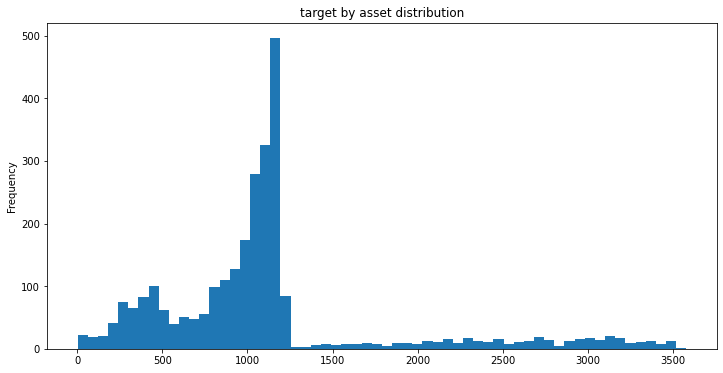

In [11]:
#Hos is target distributed in the assets?
target_by_asset = ubiquant_data.groupby(['investment_id'])['target'].count()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
target_by_asset.plot.hist(bins=60)
plt.title("target by asset distribution")
plt.show()

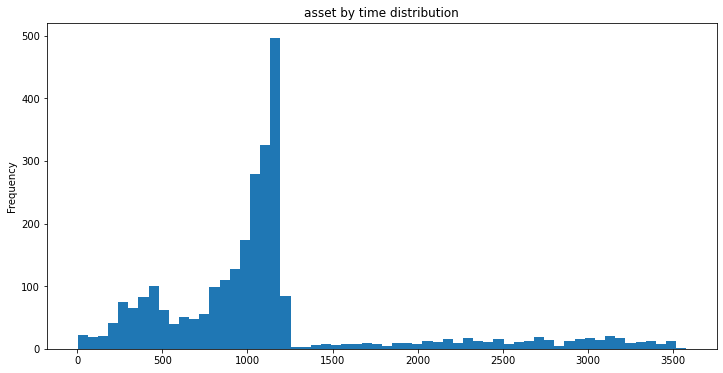

In [12]:
asset_by_time = ubiquant_data.groupby(['investment_id'])['time_id'].count()#.compute()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
asset_by_time.plot.hist(bins=60)
plt.title("asset by time distribution")
plt.show()

In [ ]:
#visualise how target is related to time_and random feature
ubiquant_data.plot(figsize=(15,4))
ubiquant_data.plot(subplots=True, figsize=(15,6))
ubiquant_data.plot(y=["target", "f_0"], figsize=(15,4))
ubiquant_data.plot(x="target", y=["f_0", "time_id"], style='.')

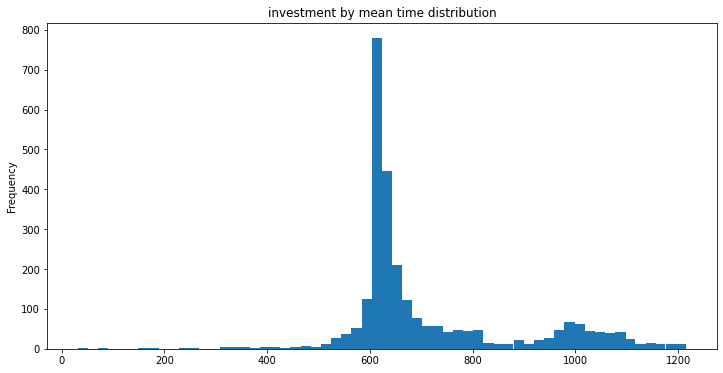

65

In [11]:
features = ubiquant_data.groupby(['investment_id'])['time_id'].mean()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
features.plot.hist(bins=60)
plt.title("investment by mean time distribution")
plt.show()

gc.collect()

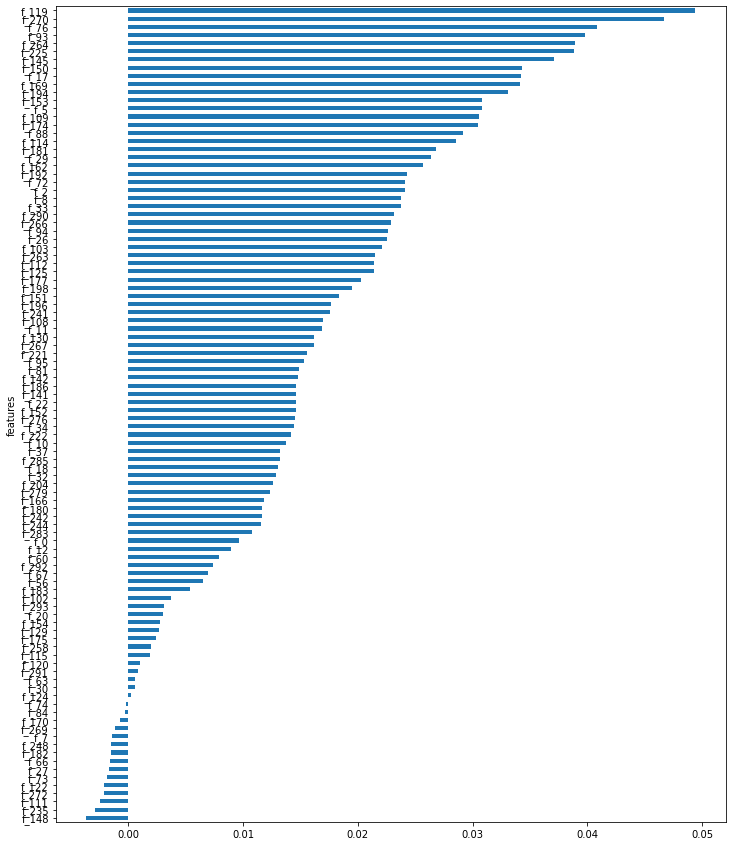

In [16]:
#rename the columns in our correlations_target df
target_feature_coeff['features']=target_feature_coeff[0]
target_feature_coeff['coeff']=target_feature_coeff[1]
target_feature_coeff.drop([0,1], axis=1)

#visualize the importance of features based on pearson's r
i = target_feature_coeff['features']
feat_importances = pd.Series(correlations, index=i)
feat_importances.nlargest(100).plot(kind='barh', figsize=(12, 15)).invert_yaxis()
plt.show()

In [80]:
cor_feats.head()

,target,0
0,-0.300781,0.009623
1,-0.231079,-0.015878
2,0.568848,0.024120
3,-1.064453,-0.034535
4,-0.531738,-0.005318


3812

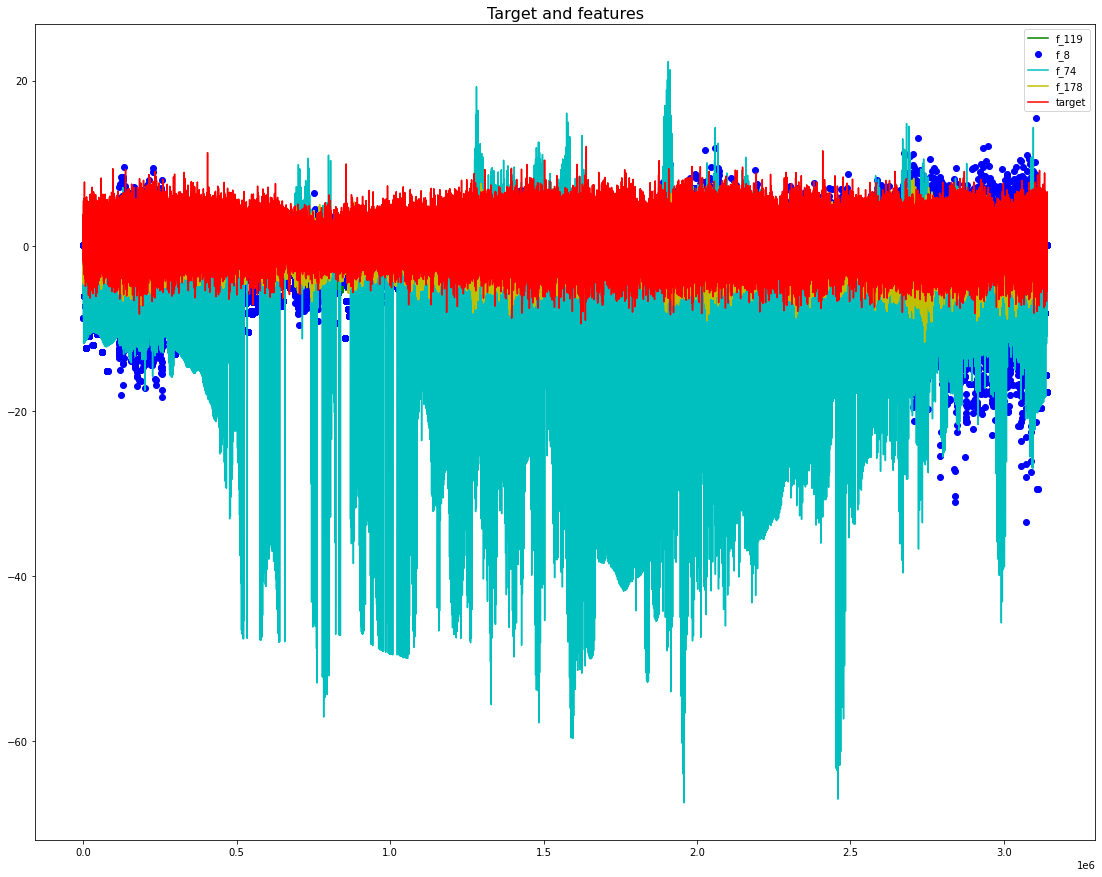

In [15]:
f = plt.figure(figsize=(19, 15))

plt.plot(ubiquant_data['f_119'], 'g')
plt.plot(ubiquant_data['f_8'], 'ob')
plt.plot(ubiquant_data['f_74'], 'c')
plt.plot(ubiquant_data['f_178'], 'y')
plt.plot(ubiquant_data['target'], '-r')
#cb = plt.colorbar()
names =['f_119','f_8','f_74','f_178','target']
plt.legend(names)
plt.title('Target and features', fontsize=16)

gc.collect()

In [17]:
#Check if and of the features f_0 to f_299 are at lest wekly corelalted with the target using pearson's r
correlations=[]
feature_columns=[]
for col in ubiquant_data.columns[4:]:
    coef = np.corrcoef(ubiquant_data['target'], ubiquant_data[col])[0][1]
    correlations.append(coef)
    feature_columns.append(col)
    
target_feature_coeff=pd.concat([pd.Series(feature_columns), pd.Series(correlations)],axis=1)
for cor in correlations:
    if cor >0.5 or cor <-0.5:
        print(f'(len({cor})) features are correlated with target')

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ubiquant_data, test_size=0.7) #select a few lines
correlated=train.corr() #test correlations
correlated.style.background_gradient(cmap='coolwarm').set_precision(2) #plot correlation matrix
gc.collect()

In [66]:
#WIll use if can find way to convert time_id to periodindex object
#periods = ubiquant_data["time_id"].astype('int16')
#p = pd.PeriodIndex(periods, freq='xMin')
# df = ubiquant_data.sample(n=4,axis='columns')
# pd.plotting.autocorrelation_plot(df.resample('y').median())

## How does the data changes after PCA?
This part of the EDA will show how PCA transforms the features.

In [ ]:
#Scale the data using standard scaler before passing it to PCA
from sklearn.preprocessing import StandardScaler
X = ubiquant_data.filter(regex=r'f_*', axis=1)
y =ubiquant_data['target']
# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)


In [ ]:
gc.collect()

In [ ]:
#Decompose the features into two components - for 2=D visualisation
#and to check if the data can be transformed into a simpler regression problem
from sklearn.decomposition import IncrementalPCA
n_batches = 100
n_components=2
pca = IncrementalPCA(
    copy=False,
    n_components=n_components,
    batch_size=(n_batches))
pca_data=pca.fit(X_scaled)


In [ ]:
#how do our components relate to the target?
y=ubiquant_data['target']
plot = plt.scatter(pca_data[:,0], pca_data[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y))
plt.show()

gc.collect()

In [ ]:
#how do our components relate to the number of investments_id?
y=ubiquant_data['investment_id'].count()
plot = plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y))
plt.show()

gc.collect()

### Can we visualise the effect of PCA without pre-selecting number of components to decompose to?

In [ ]:
####Memory issues when I attempt to do PCA without setting n_components
gc.collect() #garbage collect
#PCA on dataset and let it auto-select how much to decompose to
from sklearn.decomposition import IncrementalPCA
n_batches = 100
pca = IncrementalPCA(
    copy=False,
    batch_size=(n_batches))
pca.fit(X_scaled)

In [ ]:
plot = plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y))
plt.show()